In [1]:
from fastai.text import *
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
path = 'data/Yelp/'
df_meta = pd.read_csv(path+'output_meta_yelpResData_NRYRcleaned.txt', sep=' ', header=None)

df_meta.head(3)

,0,1,2,3,4,5,6,7,8
0,9/22/2012,GtwU21YOQn-wf4vWRUIx6w,bNYesZ944s6IJVowOnB0iA,pbEiXam9YJL3neCYHGwLUA,N,0,0,0,5
1,9/22/2012,0LpVTc3,TRKxLC3y-ZvP45e5iilMtw,pbEiXam9YJL3neCYHGwLUA,N,0,0,0,5
2,9/19/2012,tljtLzf68Fkwf,0EMm8umAqXZzyhxNpL4M9g,pbEiXam9YJL3neCYHGwLUA,N,0,0,2,3


In [3]:
df_reviews = pd.read_csv(path+'output_review_yelpResData_NRYRcleaned.txt', sep='\r', header=None)
df_reviews.head(3)

,0
0,"Unlike Next, which we'd eaten at the previous ..."
1,Probably one of the best meals I've had ever. ...
2,Service was impeccable. Experience and present...


In [4]:
df_meta_reviews = pd.merge(df_meta, df_reviews, left_index=True, right_index=True)
df_meta_reviews = df_meta_reviews.rename(columns={'0_x': 'date', 1: 'id', 2: 'id2', 3: 'id3', 4:'label', '0_y': 'text'})
df_meta_reviews = df_meta_reviews[['label', 'text']]

In [5]:
df_meta_reviews.head(3)

,label,text
0,N,"Unlike Next, which we'd eaten at the previous ..."
1,N,Probably one of the best meals I've had ever. ...
2,N,Service was impeccable. Experience and present...


In [6]:
# Create training and validation split of data (it keeps the same % as in the original dataset)
X_train, X_test, y_train, y_test = train_test_split(df_meta_reviews, df_meta_reviews['label'], test_size=0.3, random_state=0, stratify=df_meta_reviews['label'])

# Check split
#X_train[['label', 'text']].groupby(['label']).agg(['count'])

# Generate bool is_valid to flag validiation
X_train['is_valid'] = False
X_test['is_valid'] = True

# Generate final dataset
df = X_train.append(X_test)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


## Language model

In [7]:
#data_lm = TextLMDataBunch.from_df(path=path, 
#                                  train_df=df,
#                                  valid_df=df,
#                                  label_cols='label',
#                                  text_cols='text')

bs = 48
data_lm = (TextList.from_df(df, path, cols='text')
         .split_by_rand_pct(0.1)
         .label_for_lm()
         .databunch(bs=bs))

In [8]:
data_lm.save('YelpChi_lm.pkl')

In [9]:
data_lm = load_data(path, 'YelpChi_lm.pkl', bs=bs)

In [10]:
data_lm.show_batch()

idx,text
0,"the house ... what more could you ask for ? we shared a communal table , enjoyed the farm - y ( aka home for me ) decor , and xxunk at all the adorable mini mason jars on our table and displayed around the place . all the dishes were delicious and easy enough to share . i would definitely go with people you know , who are n't"
1,"plate . i get that xxup ge was trying to go for contrast , bold flavors , and wild combinations when he paired the lamb with cracked wheat and xxmaj clementine marmalade , but , no . xxmaj the xxmaj clementine marmalade was far too tart ; at first taste , i xxunk my entire face ( documented by brianq ) . xxmaj the cracked wheat was okay , but"
2,"jerusalem salad . xxmaj awesome xxmaj lentil soup as well . xxmaj they claim it is 100 % vegetarian , but it sure tastes like it has chicken stock in it to me . xxmaj we probably eat here nearly once it week we like it so much . xxmaj now if only their hummus was as good as xxmaj pita xxmaj inn , then they 'd be xxunk !"
3,"the crust becomes so thick and doughy and dry , it 's almost impossible to eat without dipping it in a bowl of sauce . i had to start eating backwards from the delicious crust ( still delicious as leftovers ) and throwing the rest away once it was gone . i did note a ridiculous m - f lunch special - less than $ 5 for a 7 inch"
4,and a 1 / 2 chicken . xxmaj the 1 / 2 chicken comes with two sides so i had garlic mashed potatoes and corn . xxmaj the chicken was pretty good - moist and the rub they put on it was tasty . xxmaj the potatoes were disgusting . xxmaj could n't finish them . xxmaj the corn was ok . xxmaj the pizza had that kind of fake


In [11]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


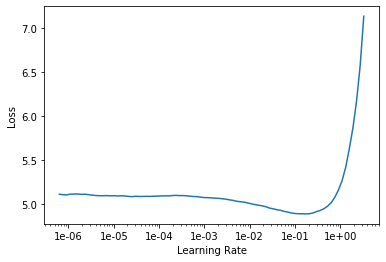

In [13]:
#learn.recorder.plot(skip_end=15)
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.809704,3.662015,0.308874,21:15


In [15]:
learn.save('fit_head')

In [16]:
learn.load('fit_head');

In [17]:
learn.unfreeze()

In [18]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.498100,3.481936,0.330475,25:02
1,3.412442,3.392594,0.342079,25:02
2,3.355345,3.338157,0.348420,25:01
3,3.262223,3.303142,0.353294,24:58
4,3.191457,3.283236,0.356495,24:59
5,3.077539,3.275042,0.358157,25:02
6,3.009444,3.275616,0.358139,25:03
7,2.903677,3.286076,0.358206,25:05
8,2.837318,3.296849,0.357719,25:04
9,2.816616,3.304133,0.357191,25:02


In [19]:
learn.save('fine_tuned')

In [20]:
learn.load('fine_tuned');

In [21]:
TEXT = "I do not liked this restaurant because"
N_WORDS = 40
N_SENTENCES = 2
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.76) for _ in range(N_SENTENCES)))

I do not liked this restaurant because i 've been here on several occasions and have never been impressed . The food is good and the service is above average . If you are trying to avoid the crowds , the wait staff is not
I do not liked this restaurant because i was so excited to try it for the first time , but i guess my expectations were high . We ordered the salad bar , which was cold and not good . The sushi was good ,


In [22]:
learn.save_encoder('fine_tuned_enc')

## Classifier

In [23]:
# Change the order of the columns
df = df[['text', 'label', 'is_valid']]
df.head(3)

,text,label,is_valid
6575,after a shaky start (we were completely overwh...,N,False
9976,I adore this place! Their patio is absolutely ...,N,False
41784,"There is a great quote from Maupin's ""Tales Of...",N,False


In [ ]:
data_clas = (TextList.from_df(df, path, cols=['text', 'label', 'is_valid'], vocab=data_lm.vocab)
             #grab all the text files in path
             .split_from_df()
             #split by is_valid column (that only keeps 'train' and 'test' so no need to filter)
             .label_from_df(cols='label')
             #label them all with their folders
             .databunch(bs=bs))

#data_clas.save(path, 'data_clas.pkl')
#data_clas

In [90]:
#data_clas.save('models/data_clas.pkl')


FileNotFoundError: ignored

In [91]:
data_clas.show_batch()

text,target
"xxbos i honestly hate this place . xxmaj let me preface this by saying ... i love beer . i love xxmaj belgian beer . i love the beers on their beer menu . i like food . i love going out to eat . i live in the city , and love the area where xxmaj hopleaf is located xxrep 4 . but i hate this place . i",N
"xxbos i 've been here twice , because i felt that there might be opening jitters ... there were n't and there still are n't . i think most of you on here know i have a slight southside bias , so when i am raving this much about a place up north you xxup know it 's good . xxup real xxup good . xxmaj as in , """,N
"xxbos xxmaj utterly fantastic . xxmaj we did the 9 course tasting menu . xxmaj they threw in three extra tastes , so we ended with 12 courses for $ 110 / person . xxup byob , no corkage fee . xxmaj we brought a half bottle of xxunk and a bottles of xxmaj vouvray and xxmaj pinot xxmaj noir . xxmaj atmosphere : xxmaj it is really just a",N
"xxbos xxmaj taking advantage of xxmaj restaurant xxmaj week 2011 , i decided it would be nice to try a new restaurant in the xxmaj gold xxmaj coast for once ( one can only eat at xxmaj hub 51 and xxmaj sushi xxmaj samba so much ) . xxmaj with my love of bbq and being skeptical of any place selling it that is n't named xxmaj smoque , i",N
"xxbos xxmaj once again , it 's time for the "" xxmaj fat xxmaj american xxmaj ca n't xxmaj figure xxmaj out xxmaj foreign xxmaj cuisines "" show ! xxmaj today , we 're returning to xxmaj greece - the xxmaj island regions in particular , because i 've just been to the xxmaj greek xxmaj islands xxmaj restaurant for a lovely dinner ! i had a relative from back",N


In [96]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)
len(data_clas.vocab.itos) == len(data_lm.vocab.itos)

FileNotFoundError: ignored

In [ ]:
#import os
#os.chdir("/content/drive/My Drive/Dissertation")

In [92]:
#!pwd

/content/drive/My Drive/Dissertation


In [95]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

FileNotFoundError: ignored

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()